$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
# AdEx: the Adaptive Exponential Integrate-and-Fire model

**Book chapters**

The Adaptive Exponential Integrate-and-Fire model is introduced in [Chapter 6 Section 1](http://neuronaldynamics.epfl.ch/online/Ch6.S1.html).

**Python classes**

Use function `.AdEx.simulate_AdEx_neuron` to run the model for different input currents and different parameters. Get started by running the following script:

In [ ]:
!pip install brian2
!pip install neurodynex3

In [1]:
import brian2 as b2
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, input_factory

import ipywidgets as widgets
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
matplotlib.rcParams["figure.figsize"] = (6, 6)

In [3]:
current = input_factory.get_step_current(10, 250, 1.0 * b2.ms, 65.0 * b2.pA)

In [4]:
state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron(
    I_stim=current, simulation_time=400 * b2.ms
)

nr of spikes: 10


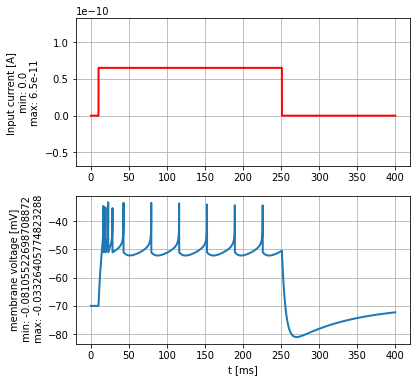

In [5]:
plot_tools.plot_voltage_and_current_traces(state_monitor, current)
print("nr of spikes: {}".format(spike_monitor.count[0]))

A step-current (top panel, red) is injected into an AdEx neuron. The membrane voltage of the neuron is shown in blue (bottom panel).

-----------

## Exercise 1: Adaptation and firing patterns

We have implemented an Exponential Integrate-and-Fire model with a single adaptation current `w` :

$$\left[\begin{array}{ccll}
{\displaystyle \tau_m \frac{du}{dt}} &=& -(u-u_{rest}) + \Delta_T exp(\frac{u-\vartheta_{rh}}{\Delta_T}) - R w + R I(t) \\[.2cm]
{\displaystyle \tau_w \frac{dw}{dt}} &=& a (u-u_{rest}) -w  + b \tau_w \sum_{t^{(f)}} \delta (t - t^{(f)})
 \\[.2cm]
\end{array}\right.$$

### Question 1.1
When you simulate the model with the default parameters, it produces the voltage trace shown above. Describe that firing pattern. Use the terminology of Fig. 6.1 in [Chapter 6.1](http://neuronaldynamics.epfl.ch/online/Ch6.S1.html).

### Answer 1.1
**The voltage trace shown above corresponds to a tonic pattern with an initial burst. After a short bursting period the neuron exhibits regular firing.**

### Question 1.2
Call the function `.AdEx.simulate_AdEx_neuron` with different parameters and try to create **adapting**, **bursting** and **irregular** firing patterns. Table 6.1 in [Chapter 6.2](http://neuronaldynamics.epfl.ch/online/Ch6.S2.html) provides a starting point for your explorations.

In order to better understand the dynamics, it is useful to observe the joint evolution of $u$ and $w$ in a phase diagram. Use the function `.AdEx.plot_adex_state` to get more insights. Fig. 6.3 in [Chapter 6.2](http://neuronaldynamics.epfl.ch/online/Ch6.S2.html) shows a few trajectories in the phase diagram.

If you want to set a parameter to 0, Brian still expects a unit. Therefore use $a = 0*b2.nS$ instead of $a = 0$.

If you do not specify any parameter, the following default values are used:

In [4]:
MEMBRANE_TIME_SCALE_tau_m = 5 * b2.ms
MEMBRANE_RESISTANCE_R = 500 * b2.Mohm
V_REST = -70.0 * b2.mV
V_RESET = -51.0 * b2.mV
RHEOBASE_THRESHOLD_v_rh = -50.0 * b2.mV
SHARPNESS_delta_T = 2.0 * b2.mV
ADAPTATION_VOLTAGE_COUPLING_a = 0.5 * b2.nS
ADAPTATION_TIME_CONSTANT_tau_w = 100.0 * b2.ms
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = 7.0 * b2.pA

### Answer 1.2

**In the following interactive plot, the $u_{reset}, a$ and $b$ parameters can be modified arbitrarily.**

In [33]:
@widgets.interact
def adex_try_params_with_phase(
    u_r=(-100, 0, 1), a=(-1, 1, 0.01), b=(-10, 10, 1), tau_w=(100, 200, 1)
):

    state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron(
        tau_w=tau_w * b2.ms,
        tau_m=10 * b2.ms,
        I_stim=current,
        simulation_time=400 * b2.ms,
        v_reset=u_r * b2.mV,
        a=a * b2.nS,
        b=b * b2.pA,
    )

    data = state_monitor.get_states()

    fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=False)
    ax[0].plot(data["t"], data["v"])
    ax[0].set_xlabel("time (s)")
    ax[0].set_ylabel("u (V)")
    ax[1].plot(data["v"], data["w"])
    ax[1].set_xlabel("u (V)")
    ax[1].set_ylabel("w (A)")

interactive(children=(IntSlider(value=-50, description='u_r', max=0, min=-100), FloatSlider(value=0.0, descrip…

#### See below the parameters that were chosen to elicit the three kinds of firing patterns, and the respective plots that illustrate these patterns.

#### Adapting:
- **$a$ is set to 0, and $u_{reset}$ is close to the resting potential**
- **$b$ is small and $\tau_w$ is large, so that the current accumulates over time, causing the gradual prolongation of the refractory period**

#### Bursting:
- **$u_{reset}$ is higher than the firing threshold $\vartheta$, which produces series of bursts**
- **$b$ is large, so that it accumulates during the bursting period and produces reset detours**

#### Irregular:
- **$u_{reset}$ is slightly higher than the firing threshold $\vartheta$ and $b$ is large, so that the pattern alternates between direct resets and detours**

In [39]:
parameter_df = pd.DataFrame.from_dict(
    {
        "tau_w": [200, 100, 100],
        "u_r": [-60., -45., -47.],
        "a": [0., -1., -1],
        "b": [3., 7., 7.],
    },
    orient="index",
    columns=["adapting", "bursting", "irregular"],
)

In [40]:
parameter_df

,adapting,bursting,irregular
tau_w,200.0,100.0,100.0
u_r,-60.0,-45.0,-47.0
a,0.0,-1.0,-1.0
b,3.0,7.0,7.0


In [37]:
def adex_with_params(pattern):

    state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron(
        I_stim=current,
        simulation_time=400 * b2.ms,
        tau_m=10 * b2.ms,
        tau_w=parameter_df.loc["tau_w", pattern] * b2.ms,
        v_reset=parameter_df.loc["u_r", pattern] * b2.mV,
        a=parameter_df.loc["a", pattern] * b2.nS,
        b=parameter_df.loc["b", pattern] * b2.pA,
    )

    plot_tools.plot_voltage_and_current_traces(state_monitor, current)
    plt.title(f"Pattern: {pattern}")

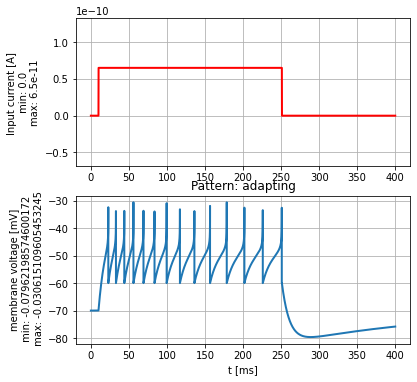

In [41]:
adex_with_params("adapting")

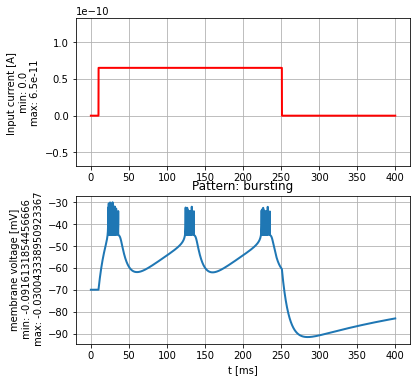

In [105]:
adex_with_params("bursting")

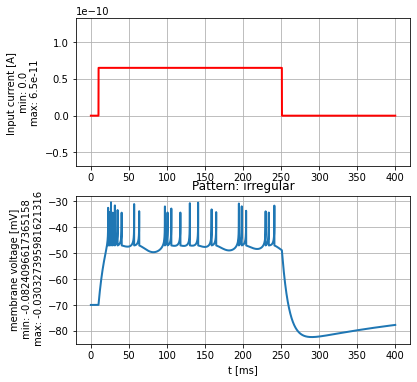

In [106]:
adex_with_params("irregular")

-----------

## Exercise 2: phase plane and nullclines

### Question 2.1:
First, try to get some intuition on shape of nullclines by plotting or simply sketching them on a piece of paper and answering the following questions.

1.  Plot or sketch the $u$ and $w$ nullclines of the AdEx model ($I(t) = 0$).
2.  How do the nullclines change with respect to $a$?
3.  How do the nullclines change if a constant current $I(t) = c$ is applied?
4.  What is the interpretation of parameter $b$?
5.  How do flow arrows change as $\tau_w$ gets bigger?

### Answer 2.1.1

#### 1. The interactive figure below plots the $u$ and $w$ nullclines with given $a, b, \tau_w$ and constant input ($c$) parameters.
#### 2. $a$ determines the slope of the $w$ nullcline (except for the jump at $u=\vartheta$).
#### 3. A constant input shifts the $u$ nullcline upwards.
#### 4. Parameter $b$ is interpreted as a jump current at the instant of the firing. On the figure, it determines the length of the vertical segment of the w nullcline. If $b$ is zero, the w nullcline is linear. A nonzero value of $b$ creates a step in the curve at the firing threshold, as due to the $b\tau_w \sum_{t^{(f)}} \delta(t - t^{(f)})$ term a larger $w$ is required to keep $\frac{dw}{dt}$ constantly zero.
#### 5. Similarly, $\tau_w$ increases the length of the vertical segment of the w nullcline.

The nullcline of $u$ is calculated as:

$\tau_m \frac{du}{dt} = -(u - u_{rest}) + \Delta_T e^{\frac{u - \vartheta_{rh}}{\Delta_T}} - Rw + RI(t)$

$\tau_m \frac{du}{dt} = 0 \Leftrightarrow -(u - u_{rest}) + \Delta_T e^{\frac{u - \vartheta_{rh}}{\Delta_T}} - Rw + RI(t) = 0 \Leftrightarrow w = \frac{-(u - u_{rest}) + \Delta_T e^{\frac{u - \vartheta_{rh}}{\Delta_T}}}{R} + I(t)$

The nullcline of $w$ is calculated as:

$\tau_w \frac{dw}{dt} = a (u - u_{rest}) - w + b\tau_w \sum_{t^{(f)}} \delta(t - t^{(f)})$

$\tau_w \frac{dw}{dt} = 0 \Leftrightarrow a (u - u_{rest}) - w + b\tau_w \sum_{t^{(f)}} \delta(t - t^{(f)}) = 0 \Leftrightarrow w = a (u - u_{rest}) + b\tau_w \sum_{t^{(f)}} \delta(t - t^{(f)})$

In [8]:
u_values = np.linspace(-80, 0, 1000)

In [9]:
def u_nullcline(u, I_t=0 * b2.pA):

    u = u * b2.mV

    return (
        -(u - V_REST)
        + SHARPNESS_delta_T * np.exp((u - RHEOBASE_THRESHOLD_v_rh) / SHARPNESS_delta_T)
    ) / MEMBRANE_RESISTANCE_R + I_t

In [21]:
def w_nullcline(
    u,
    a=ADAPTATION_VOLTAGE_COUPLING_a,
    b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b,
    tau_w=ADAPTATION_TIME_CONSTANT_tau_w,
):

    u = u * b2.mV

    delta = int(u >= RHEOBASE_THRESHOLD_v_rh)

    return a * (u - V_REST) + b * tau_w / b2.ms * delta

In [43]:
@widgets.interact
def plot_nullclines(
    a=(-10, 10, 1), b=(-10, 10, 1), tau_w=(10, 300, 10), I_t=(0, 100, 1)
):

    u_null = np.array([u_nullcline(u, I_t=I_t * b2.pA) for u in u_values])
    w_null = np.array(
        [
            w_nullcline(u, a=a * b2.nS, b=b * b2.pA, tau_w=tau_w * b2.ms)
            for u in u_values
        ]
    )

    plt.plot(u_values, u_null, label="u nullcline", lw=3, alpha=0.8)
    plt.plot(u_values, w_null, label="w nullcline", lw=3, alpha=0.8)

    plt.xlabel("u (mV)")
    plt.ylabel("w (A)")
    plt.ylim(-1e-9, 1e-9)
    plt.xticks(np.linspace(-80, 0, 11))
    plt.legend()

interactive(children=(IntSlider(value=0, description='a', max=10, min=-10), IntSlider(value=0, description='b'…

### Question 2.2:

Can you predict what would be the firing pattern if $a$ is small (in the order of $0.01 nS$)? To do so, consider the following 2 conditions:

1.  A large jump $b$ and a large time scale $tau_w$.
2.  A small jump $b$ and a small time scale $tau_w$.

Try to simulate the above conditions, to see if your predictions were true.

### Answer 2.2

#### My guess:

#### 1. A large jump with a long time scale would cause low-frequency tonic, or perhaps adaptive firing.
#### 2. A small jump with a small time scale would result in high-frequecy tonic firing.

------------

#### The figure below illustrates the actual connection between the $b$ and $\tau_w$ parameters and the firing pattern:

#### 1. A low-frequency tonic pattern with an initial burst is elicited. For very large values of $b$ and $\tau_w$, firing is irregular and there are only a few spikes.
#### 2. A high-frequency tonic pattern with an initial burst is elicited.

In [31]:
@widgets.interact
def adex_small_a(b=(0, 50, 1), tau_w=(10, 200, 10)):

    state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron(
        a=0.01 * b2.nS,
        I_stim=current,
        simulation_time=400 * b2.ms,
        b=b * b2.pA,
        tau_w=tau_w * b2.ms,
    )

    plot_tools.plot_voltage_and_current_traces(state_monitor, current)

interactive(children=(IntSlider(value=25, description='b', max=50), IntSlider(value=100, description='tau_w', …

### Question 2.3:

To learn more about the variety of patterns the relatively simple neuron model can reproduce, have a look the following publication: Naud, R., Marcille, N., Clopath, C., Gerstner, W. (2008). [Firing patterns in the adaptive exponential integrate-and-fire model](http://link.springer.com/article/10.1007/s00422-008-0264-7). Biological cybernetics, 99(4-5), 335-347.